## Análise utilizando algoritmos de ML

### Pontos importantes
- frequencias estimuladas (total de 40): 8.0, 8.2, ... 15.16, 15.18.
- taxa de amostragem: 250 Hz

### Analisar os 'momentos' em que ocorrem evocação do sinal SSVEP

1. Criar o objeto `MNE` a partir dos dados do participante;
2. Aplicar no objeto  `MNE` o filtro passa-faixa nos valroes de 6 - 18 Hz;
3. Criar cópias do `MNE` com fatias de tempo menores para analisar momentos que ocorrem estimulos ou não;
  - 0.0 - 0.5 segundos e 2.5 - 3.0 segundos ocorre apenas ruído;
  - 0.5 - 2.5 segundos ocorre sinal SSVEP (com ruídos);
4. Com so sinais separados em objetos `MNE`, aplicar a `FFT`, para que seja possível plotar gráficos que contenham (ou não) as informações.
  - Os dados devem ser plotados no dominio da frequencia (após a transformada de Fourier). O FFT pode ser realizado pela biblioteca scipy.fft.
  - Deve ser observado que as janelas (a) com o ruído não aparecerão de fato o sinal SSVEP.

  ### Extração de características

Uma característica importante de acordo com o artigo base do dataset `BETA` é o *signal-to-noise ratio* (SNR).

```Incluir equação SNR```

Ao final desta etapa, será obtido um vetor de características.
Estas podem ser:
- `SNR` (obrigatósia);
- Maior valor espectral (FFT);
- Média dos valores espectrais (FFT)

Dimensionalidade dos dados será da seguinte forma:

`40 , 4 , 64 , 750` -> 40 targets, 4 trials, 64 canais e 750 valores
`160 , 64 (SNR) + 64 (média) + 64  (maior) ...`
Resultando em `160, 192`.

### Seleção de características e classificação

Como existem diversos eletrodos (canais) que nao obtém sinal SSVEP, podemos extrair características que não contribuem para a classificação dos dados.

Podemos utilizar o método `RFE` (*Recursive Feature Elimination*) aplicando por meio de `sklearn.feature_selection.RFE`, aprimorando o parâmetro `n_features_to_select` até obter o melhor resultado de classificação.

Para a classificação propriamente fita, é considerando o uso do método `SVM.`

In [19]:
# imports

from scipy.io import loadmat
import numpy as np
import mne

In [20]:
# pré-carregamento

beta = loadmat(f"datasets/beta/S2.mat")['data'][0][0]
data = beta[0]
print(data.shape)


(64, 750, 4, 40)


In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
from sklearn.preprocessing import LabelEncoder
import mne


# definições de filtros

def butter_bandpass(data, lowcut, highcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=512, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=512, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

In [24]:

def print_graphs(data):
    for i in range(0, 84, 3):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 84, 3):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 84, 3):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

In [21]:
data_resh = data.reshape(data.shape[0], data.shape[1], data.shape[2] * data.shape[3])
frequencies = np.array(list(beta[1]['freqs'][0][0].flatten()) * 4)
print(data_resh.shape, frequencies.shape)

# criação do objeto MNE
n_channels = 64
sfreq = beta[1]['srate'][0][0][0][0]
ch_names = [beta[1]['chan'][0][0][i][3][0] for i in range(64)]
ch_types = ['eeg'] * 64
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

(64, 750, 160) (160,)


<Info | 7 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 250.0 Hz
>

(160, 64, 750)


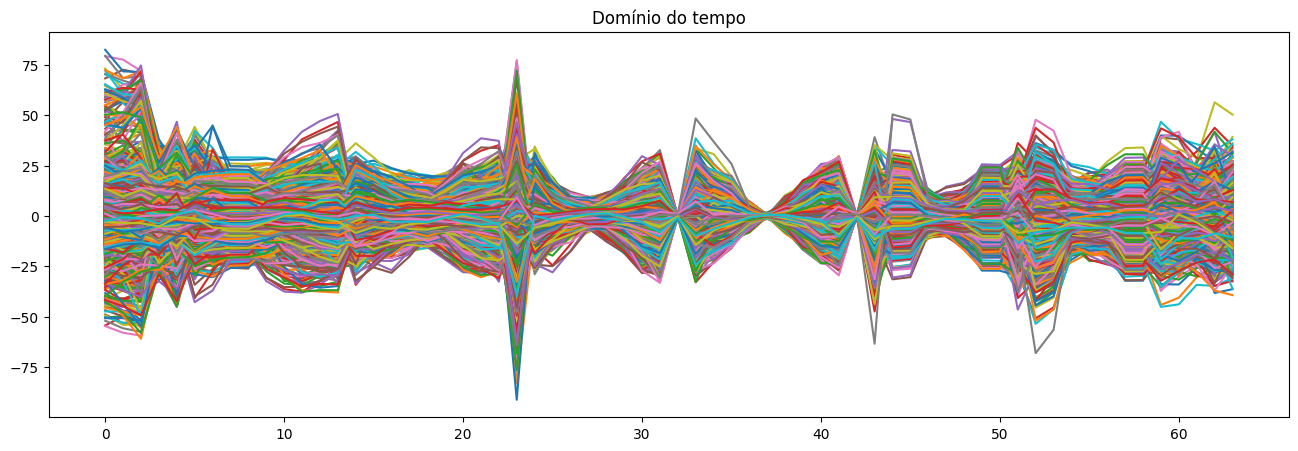

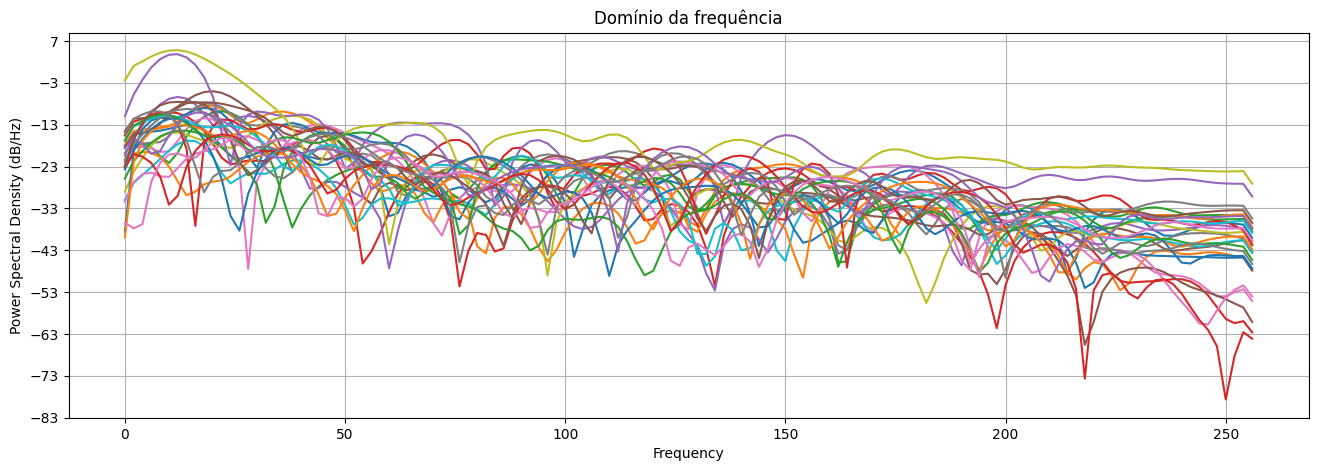

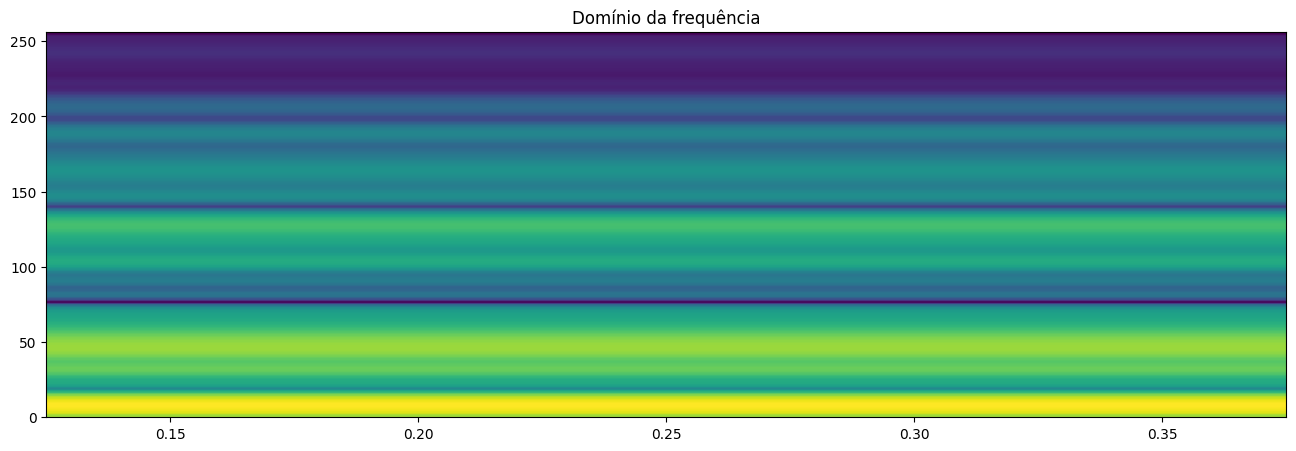

Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated


Number of events,160
Events,10.0: 410.2: 410.4: 410.6: 410.8: 411.0: 411.2: 411.4: 411.6: 411.8: 412.0: 412.2: 412.4: 412.6: 412.8: 413.0: 413.2: 413.4: 413.6: 413.8: 414.0: 414.2: 414.4: 414.6: 414.8: 415.0: 415.2: 415.4: 415.6: 415.8: 48.0: 48.2: 48.4: 48.6: 48.8: 49.0: 49.2: 49.4: 49.6: 49.8: 4
Time range,0.000 – 2.996 s
Baseline,off


In [28]:
from sklearn.preprocessing import LabelEncoder

data = data_resh.swapaxes(0, 2)
data = data.swapaxes(1, 2)
print(data.shape)

# imprimindo gráficos dos dominios de tempo e frequencia
rcParams['figure.figsize'] = [16., 5.]
print_graphs(data)

le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(frequencies))),
    np.zeros(frequencies.shape[0], dtype=int),
    le.fit_transform(frequencies))
)
event_dict = { '8.0': 0, '8.2': 1, '8.4': 2, '8.6': 3, '8.8': 4, '9.0': 5, '9.2': 6, '9.4': 7, '9.6': 8, '9.8': 9, '10.0': 10, '10.2': 11, '10.4': 12, '10.6': 13, '10.8': 14, '11.0': 15, '11.2': 16, '11.4': 17, '11.6': 18, '11.8': 19, '12.0': 20, '12.2': 21, '12.4': 22, '12.6': 23, '12.8': 24, '13.0': 25, '13.2': 26, '13.4': 27, '13.6': 28, '13.8': 29, '14.0': 30, '14.2': 31, '14.4': 32, '14.6': 33, '14.8': 34, '15.0': 35, '15.2': 36, '15.4': 37, '15.6': 38, '15.8': 39}
mne_data = mne.EpochsArray(data, info, events, event_id=event_dict)

mne_data

In [ ]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

for i in range(len(mne_data)):
    # view = mne_data.compute_psd(method='welch', fmin=3, fmax=13)
    view = mne_data[i].compute_psd(method='multitaper', fmin=8, fmax=16,
                                   verbose=False)
    view.plot(show=False)
    print()
    plt.title('Domínio da frequência')
    plt.axvline(x=float(list(mne_data[i].event_id)[0]), linestyle='--',
                color='green')
    plt.show()
print()

Os gráficos acima impressos não correspondem aos canais parietais e osciptais que foram de fato analisados, **Pz, PO3, PO5, PO4, PO6, POz, O1, Oz, e O2**, conforme descrito pelo artigo. É necessário filtrar os canais que não correspondem aos determinados.

In [ ]:
desired_channels = ['PZ', 'PO3', 'PO5', 'PO4', 'PO6', 'POZ', 'O1', 'OZ', 'O2']
channels_data = mne_data.copy().pick_channels(desired_channels)

for i in range(len(mne_data)):
    view = channels_data[i].compute_psd(method='multitaper', fmin=8, fmax=16,
                                   verbose=False)
    view.plot(show=False)
    print()
    plt.title('Domínio da frequência')
    plt.axvline(x=float(list(channels_data[i].event_id)[0]), linestyle='--',
                color='green')
    plt.show()
print()

In [7]:
# Estimando o ruído de fundo

# intervalos de tempo sem estímulo (0 a 0,5 segundos e 2,5 a 3 segundos)
base_start = 0
base_end = 125
rest_start = 625
rest_end = 750

# a base de dados foi copiada para uma nova variável, a fim de garantir que sua forma original não seja alterada
aux_data = data.copy()

# declaração da lista que armazenará a média das médias de potência de todos os canais para estimar o ruído de fundo
estimated_background_noise =[]

 # no exemplo apresentado, utiliza-se apenas uma amostra. Nesta implementação, a estimativa de ruído de fundo ocorrerá em 
 # todas as entradas da base de dados
for i in aux_data:    
    noise_power = [] # armazena uma lista com as médias de potência para cada canal

    for channel_data in i:
        fft_result = np.fft.fft(channel_data)
        # densidade espectral de potência (PSD)
        psd = np.abs(fft_result) ** 2
        # média da potência nos intervalos de tempo sem estímulo
        base_power = np.mean(psd[base_start:base_end])
        rest_power = np.mean(psd[rest_start:rest_end])
        # média das duas médias de potência obtidas anteriormente
        mean_noise_power = (base_power + rest_power) / 2
        noise_power.append(mean_noise_power)

    # adicionando à lista as média das médias de potência de todos os canais
    estimated_background_noise.append(np.mean(noise_power))

# conversão da lista num numpy array
estimated_bg_noise = np.array(estimated_background_noise)



In [8]:
from scipy.signal import find_peaks

sr = sfreq

# frequências alvo
target_frequencies = np.arange(8, 16, 0.2)
# lista para armazenar as amplitudes nas frequências alvo
target_amplitudes = []

for i in aux_data:
    #lista auxiliar para armazenar as amplitudes de cada entrada da base de dados
    amplitude_per_freq = []

    for channel_data in i:
        fft_result = np.fft.fft(channel_data)
        psd = np.abs(fft_result) ** 2
        frequencies = np.fft.fftfreq(len(fft_result), 1 / sr)

        target_amplitudes_trial = []

        for target_frequency in target_frequencies:
            # encontrando o índice da frequência alvo no espectro de frequência
            index = np.argmin(np.abs(frequencies - target_frequency))
            # amplitude na frequência alvo
            amplitude = np.sqrt(psd[index])
            target_amplitudes_trial.append(amplitude)

        amplitude_per_freq.append(target_amplitudes_trial)
    
    target_amplitudes.append(amplitude_per_freq)
        
target_amplitudes = np.array(target_amplitudes)
target_amplitudes.shape

(160, 64, 40)

In [9]:
# criando métodos com o calculo de banda estreita e larga, a fim de executá-los a 
# cada iteração da criação do vetor de características

def adjust_target_amplitude (target_amplitudes, estimated_background_noise):
    adj_amp = target_amplitudes - estimated_background_noise
    return (adj_amp)

def narrow_band_SNR (target_amplitudes, estimated_background_noise):
    target_amplitudes_adjusted = adjust_target_amplitude(target_amplitudes, estimated_background_noise)
    banda_estreita = 10 * np.log10(target_amplitudes_adjusted / estimated_background_noise)
    return banda_estreita

def wide_band_SNR (target_amplitudes, estimated_background_noise):
    target_amplitudes_adjusted = adjust_target_amplitude(target_amplitudes, estimated_background_noise)
    total_power = np.sum(target_amplitudes_adjusted)
    banda_alta = 10 * np.log10(target_amplitudes_adjusted / total_power)
    return(banda_alta)


Seleção de características manual utilizando SVM